#PADL Week 7 Practical

This practical is all about ReLU MLPs. These are still an amazingly useful tool and can be used to solve many real problems (and are still actively used in state-of-the-art research).

We'll start by revising the application of an MLP to the breast cancer dataset, as in previous practicals. Then you'll try fitting a ReLU MLP to a given function (a sinusoid) to get an intuition for how they work. Finally, you'll try to classify a highly nonlinear 2D, two class dataset using a ReLU MLP. At the end of each exercise there are some tasks for you to do.

##1. MLP for breast cancer data revisited

I've given you the code to load the dataset and train a single hidden layer MLP. Read and understand the code, click through and then try the tasks at the end.

In [66]:
import numpy as np
from sklearn.linear_model import LogisticRegression
import torch
import matplotlib.pyplot as plt
from numpy import pi
import torch.nn as nn

Load the dataset and convert to PyTorch tensors

In [ ]:
!wget -q https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data

training_size = 400

data = np.genfromtxt('breast-cancer-wisconsin.data',delimiter=',',missing_values='?')
data = data[~np.isnan(data).any(axis=1)]

# Convert labels to binary 0/1 classes as expected by PyTorch
y_01 = np.array([0 if x==2 else 1 for x in data[:,-1]])

X = data[:,1:-1] # ignore first column and omit class variable at the end



In [ ]:
# Split train/test and convert to PyTorch tensors
X_train_tensor = torch.from_numpy(np.float32(X[:training_size]))
Y_train_tensor = torch.from_numpy(np.float32(y_01[:training_size])).unsqueeze(1)
X_test_tensor = torch.from_numpy(np.float32(X[training_size:]))
Y_test_tensor = torch.from_numpy(np.float32(y_01[training_size:])).unsqueeze(1)

Let's make sure that we understand the structure of our data. Let's start by printing the shapes of the training data inputs and labels (always a good idea!)

In [ ]:
print(X_train_tensor.shape)
print(Y_train_tensor.shape)


torch.Size([400, 9])
torch.Size([400, 1])


So, our training data comprises 400 samples. Each sample comprises a 9 dimensional input and a binary label. In other words `X_train_tensor[i,:]` is the 9D input for training sample `i` and `Y_train_tensor[i]` contains either a 0 or 1 to indicate which class it belongs to.

###Define a single hidden layer MLP

We will now define a simple MLP that we will use to solve this problem. This MLP will allow us to specify the input size and the number of neurons in the hidden layer when we instantiate it. It will contain one hidden layer followed by ReLU activation. Since this is a binary classification problem, the output layer will map the output of the hidden layer to a single output which will represent the probability of one of the classes. Since we need the output to represent a probability, we will use sigmoid to map the unconstrained value to a value between 0 and 1.

In [ ]:
class MLP(nn.Module):
    def __init__(self, inputSize, hiddenSize):
        # Call superclass constructor
        super(MLP, self).__init__()
        # Initialise components of model:
        # 1. First linear layer (hidden layer)
        self.linear1 = nn.Linear(inputSize, hiddenSize)
        # 2. ReLU layer
        self.relu = nn.ReLU()
        # 3. Second linear layer (output layer)
        self.linear2 = nn.Linear(hiddenSize, 1)
        # 4. Sigmoid layer
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Forward pass through the model:
        # x has shape batch x inputSize
        # HIDDEN LAYER
        # 1. Apply linear layer to input
        y = self.linear1(x)
        # y has shape batch x 16
        # 2. Apply ReLU to output of linear layer
        y = self.relu(y)
        # OUTPUT LAYER
        # 3. Apply linear layer to output of hidden layer
        y = self.linear2(y)
        # y has shape batch x 1
        # 4. Apply sigmoid to output of linear layer
        y = self.sigmoid(y)
        return y

Let's just remind ourselves how this model is actually used. First, we want to instantiate it. At this point, the learnable weights and biases are initialised with random values. If you've run some learning and want to start again from scratch, you need to rerun this line, otherwise the weights will be preserved from your previous training.

In [ ]:
# Instantiate MLP with 9 channel input and 16 neuron hidden layer
model = MLP(9,24)

Now let's just check that we understand the shapes of inputs and outputs to the model. Let's create some random input and put it through the model.

In [ ]:
x = torch.randn(100,9)
y = model(x)
print(y.shape)
print(torch.min(y))
print(torch.max(y))

torch.Size([100, 1])
tensor(0.4754, grad_fn=<MinBackward1>)
tensor(0.6856, grad_fn=<MaxBackward1>)


The first dimension of `x` is the batch size. We are allowed to pass many inputs through a model in parallel and this first dimension (100 in this case) represents this. The second dimension is the size of the input - in this case we have 9D input. The output has shape $100\times 1$, i.e. a scalar probability for each of the 100 inputs. We can see that the values in `y` lie between 0 and 1.

###Training the model

We're now ready to try training the model. We need to define a loss function, set up the optimiser and then run the training loop. We will use binary cross entropy loss and straightforward gradient descent. For each iteration (="epoch" because we process the entire training set in each operation - this will be different when we come to using minibatches later) of the training loop, we simply put the inputs through our model, get probabilities out (`y_predict`) and put these into the loss function to compare against the binary labels. We then perform backprop and take a gradient descent step.

In [ ]:
epochs = 5000

# Instantiate loss function (binary cross entropy loss - sigmoid applied inside model)
criterion = torch.nn.BCELoss()
# Setup optimiser
optim = torch.optim.SGD(model.parameters(), lr=0.1)

# Main training loop
for epoch in range(epochs):
    # Pass training data through model
    y_predict = model(X_train_tensor)
    # Compute BCE loss
    loss = criterion(y_predict,Y_train_tensor)
    # Backward pass and gradient step
    optim.zero_grad()
    loss.backward()
    optim.step()
    if not epoch % 200:
        # Print out the loss every 10 iterations
        print('epoch {}, loss {}'.format(epoch, loss.item()))

epoch 0, loss 1.0495636463165283
epoch 200, loss 0.13846918940544128
epoch 400, loss 0.1073453351855278
epoch 600, loss 0.0943605899810791
epoch 800, loss 0.08660207688808441
epoch 1000, loss 0.07717454433441162
epoch 1200, loss 0.07102105766534805
epoch 1400, loss 0.0658813938498497
epoch 1600, loss 0.06209591031074524
epoch 1800, loss 0.05859547480940819
epoch 2000, loss 0.05739278718829155
epoch 2200, loss 0.05405931547284126
epoch 2400, loss 0.0509163960814476
epoch 2600, loss 0.046246301382780075
epoch 2800, loss 0.03993430733680725
epoch 3000, loss 0.03830979764461517
epoch 3200, loss 0.03525777906179428
epoch 3400, loss 0.030348682776093483
epoch 3600, loss 0.02705463394522667
epoch 3800, loss 0.024649055674672127
epoch 4000, loss 0.022382941097021103
epoch 4200, loss 0.02192937396466732
epoch 4400, loss 0.021123092621564865
epoch 4600, loss 0.017289044335484505
epoch 4800, loss 0.016459466889500618


###Evaluating our model

Hopefully, the loss gradually reduced while your model trained. This is promising but the loss value is a bit hard to interpret. Let's now calculate the percentage correct classification on both the training and test sets. To convert the estimated probabilities into hard classifications, we simply threshold against 0.5. We can then compare the predictions against the actual labels.

In [ ]:
# Pass training set set through model
y_predict = model(X_train_tensor)
# Threshold probabilities to binary classes
predictions = (y_predict>0.5).float()
# Compare predicted classes to labels
correct = (predictions == Y_train_tensor).float().sum()
print("Percent training set correctly classified: {:.2f}%".format(100*correct/training_size))

# Pass test set through model
y_predict = model(X_test_tensor)
# Threshold probabilities to binary classes
predictions = (y_predict>0.5).float()
# Compare predicted classes to labels
correct = (predictions == Y_test_tensor).float().sum()
print("Percent test set correctly classified: {:.2f}%".format(100*correct/X_test_tensor.shape[0]))

Percent training set correctly classified: 100.00%
Percent test set correctly classified: 97.17%


Depending on your random seed, performance should be in the high 90s and performance on the test set will be slightly different, possibly in either direction.

###A note of caution: bias

When we split the dataset into a training and test set, we simply took the first 400 samples as training data and the remainder as test data. It is always a good idea to check whether your dataset is biased and, if so, whether the bias is the same in both the training and test sets.

In [ ]:
print("Percent of train set with class 1: {:.2f}".format(Y_train_tensor.sum()/Y_train_tensor.shape[0]))
print("Percent of test set with class 1: {:.2f}".format(Y_test_tensor.sum()/Y_test_tensor.shape[0]))

Percent of train set with class 1: 0.43
Percent of test set with class 1: 0.24


As you can see, our dataset is slightly biased (more class 0 than class 1). However, the bias is worse in the test set than training set. This might be bad.

If your goal is to maximise performance for any unseen test set, then ideally the training set would be unbiased. There are various strategies you could use for this. One option is to weight the loss by inverse class frequency. Another is to use a weighted sampling such that samples from the underrepresented class get used in training more often. But we won't worry about this for now.

If your goal is to maximise performance on the given test set then we would like the bias to be the same in both training and test set. One strategy to achieve this is to randomly shuffle the data before splitting into training and test.

###Tasks

1. Apply the same random shuffle to `X` and `y_01` before splitting into train and test. Verify that this leads to the same (or very similar) bias in each dataset. Retrain your model. Does this change performance at all?
2. Experiment with a smaller MLP - i.e. reduce the number of hidden neurons. How small can you make it while still achieving good performance? If you make it really small, eventually it can't extract any useful information from the features in which case it will only learn the bias (i.e. it will just always predict the more common class and will be right with chance performance). Can you see this happening? What performance do you get?
3. Experiment with a deeper/and or wider MLP. i.e. either add additional hidden layers or use more neurons in the hidden layers. Does performance improve? Can you see "overfitting" at some point? (Where training loss goes to almost zero but test performance gets worse).
4. It's always a good idea to know how many trainable parameters your model has. You should always think about whether your training data is large enough to allow that many parameters to be learnt or if the model is too flexible (in which case it will easily overfit your training data but probably won't generalise). Do some googling to find out how to count the number of trainable parameters in your model.

In [ ]:
np.random.seed(42)
indices = np.random.permutation(len(X))

new_X = X[indices]
new_y_01 = y_01[indices]


In [ ]:
# Split train/test and convert to PyTorch tensors
X_train_tensor = torch.from_numpy(np.float32(new_X[:training_size]))
Y_train_tensor = torch.from_numpy(np.float32(new_y_01[:training_size])).unsqueeze(1)
X_test_tensor = torch.from_numpy(np.float32(new_X[training_size:]))
Y_test_tensor = torch.from_numpy(np.float32(new_y_01[training_size:])).unsqueeze(1)

In [ ]:
print("Percent of train set with class 1: {:.2f}".format(Y_train_tensor.sum()/Y_train_tensor.shape[0]))
print("Percent of test set with class 1: {:.2f}".format(Y_test_tensor.sum()/Y_test_tensor.shape[0]))

Percent of train set with class 1: 0.35
Percent of test set with class 1: 0.34


In [ ]:
model = MLP(9,64)

In [ ]:
epochs = 5000

# Instantiate loss function (binary cross entropy loss - sigmoid applied inside model)
criterion = torch.nn.BCELoss()
# Setup optimiser
optim = torch.optim.SGD(model.parameters(), lr=0.1)

# Main training loop
for epoch in range(epochs):
    # Pass training data through model
    y_predict = model(X_train_tensor)
    # Compute BCE loss
    loss = criterion(y_predict,Y_train_tensor)
    # Backward pass and gradient step
    optim.zero_grad()
    loss.backward()
    optim.step()
    if not epoch % 200:
        # Print out the loss every 10 iterations
        print('epoch {}, loss {}'.format(epoch, loss.item()))

epoch 0, loss 0.28016263246536255
epoch 200, loss 0.2775842547416687
epoch 400, loss 0.33906298875808716
epoch 600, loss 0.28423917293548584
epoch 800, loss 0.2628036439418793
epoch 1000, loss 0.267682284116745
epoch 1200, loss 0.2694510221481323
epoch 1400, loss 0.2671090364456177
epoch 1600, loss 0.2651840150356293
epoch 1800, loss 0.2667715847492218
epoch 2000, loss 0.25784146785736084
epoch 2200, loss 0.2635774314403534
epoch 2400, loss 0.26176679134368896
epoch 2600, loss 0.2627696692943573
epoch 2800, loss 0.2725195288658142
epoch 3000, loss 0.26875001192092896
epoch 3200, loss 0.27356866002082825
epoch 3400, loss 0.2613036334514618
epoch 3600, loss 0.26108989119529724
epoch 3800, loss 0.2582619786262512
epoch 4000, loss 0.25504934787750244
epoch 4200, loss 0.2533126771450043
epoch 4400, loss 0.2507151663303375
epoch 4600, loss 0.25422948598861694
epoch 4800, loss 0.258395254611969


In [ ]:
# Pass training set set through model
y_predict = model(X_train_tensor)
# Threshold probabilities to binary classes
predictions = (y_predict>0.5).float()
# Compare predicted classes to labels
correct = (predictions == Y_train_tensor).float().sum()
print("Percent training set correctly classified: {:.2f}%".format(100*correct/training_size))

# Pass test set through model
y_predict = model(X_test_tensor)
# Threshold probabilities to binary classes
predictions = (y_predict>0.5).float()
# Compare predicted classes to labels
correct = (predictions == Y_test_tensor).float().sum()
print("Percent test set correctly classified: {:.2f}%".format(100*correct/X_test_tensor.shape[0]))

Percent training set correctly classified: 88.00%
Percent test set correctly classified: 54.42%


In [35]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Trainable parameters:", count_parameters(model))


Trainable parameters: 705


##2. Fitting a sinusoid with a ReLU MLP

As we've heard in lectures, machine learning is really just *function approximation*. In the next exercise we will literally try to approximate a given function. We will train an MLP to take one input, $x$, and approximately output $\sin(x)$. Working with a simple 1D function is nice as we can visualise what the network is learning (and you will see how exactly a ReLU MLP approximates a function).

###Create training data

We will uniformly sample 200 values of $x$ from $0$ to $2\pi$. The labels will simply be $\sin(x)$ for all these $x$ values. These will form our training data. We can plot $x$ against the labels to see the function we are trying to learn.

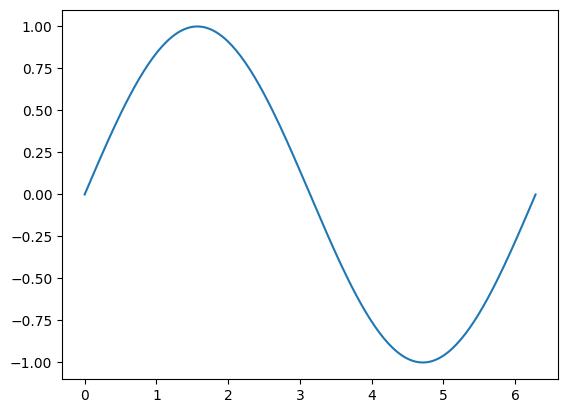

In [68]:
x = torch.linspace(0,2*pi,200).unsqueeze(1)
label = torch.sin(x)
plt.plot(x,label)

###Tasks

1. Create a small MLP, `Sin()`, that takes one input, has a single hidden layer with 16 neurons and ReLU activation then an output layer with one output and no activation. This should require only small adaptation from the MLP used in exercise 1.
2. Decide on what loss function to use. The task here is regression not classification (you are predicting a continuous value). So don't use binary cross entropy loss.
3. Train your model. The training loop will be similar to exercise 1: pass the inputs `x` through your model, get predicted outputs, compare to `label` with your loss function and take a gradient descent step. Keep an eye on the loss value during training. If it's not reducing fast enough, increase learning rate (or try switching to the Adam optimiser). If it's diverging and going crazy, reduce the learning rate.
4. Once training has converged, plot the output of your network and compare it to the ground truth sinusoid. How well does it approximate the function? Can you see how ReLU is using straight line segments to approximate a curved function?
5. Repeat the above but make your network smaller (e.g. reduce the hidden neurons to 8). How good is the approximation now?


In [54]:
class Sin(nn.Module):
    def __init__(self, hiddenSize):
        # Call superclass constructor
        super(Sin, self).__init__()
        # Initialise
        self.linear1 = nn.Linear(1, hiddenSize)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(hiddenSize, 1)

    def forward(self, x):
        # Forward pass through the model:
        # x has shape batch x inputSize
        # HIDDEN LAYER
        # 1. Apply linear layer to input
        y = self.linear1(x)
        # y has shape batch x 16
        # 2. Apply ReLU to output of linear layer
        y = self.relu(y)
        # OUTPUT LAYER
        # 3. Apply linear layer to output of hidden layer
        y = self.linear2(y)
        # y has shape batch x 1
        return y

In [62]:
sin_model = Sin(16)
epochs = 5000
criterion = torch.nn.L1Loss()
optim = torch.optim.Adam(sin_model.parameters(), lr=0.01)

# Main training loop
for epoch in range(epochs):
    # Pass training data through model
    y_predict = sin_model(x)
    # Compute BCE loss
    loss = criterion(y_predict, label)
    # Backward pass and gradient step
    optim.zero_grad()
    loss.backward()
    optim.step()
    if not epoch % 200:
        # Print out the loss every 10 iterations
        print("epoch {}, loss {}".format(epoch, loss.item()))


epoch 0, loss 1.2572177648544312
epoch 200, loss 0.1039065569639206
epoch 400, loss 0.029949691146612167
epoch 600, loss 0.01991695910692215
epoch 800, loss 0.019291505217552185
epoch 1000, loss 0.018909748643636703
epoch 1200, loss 0.01859576627612114
epoch 1400, loss 0.019429970532655716
epoch 1600, loss 0.01797902025282383
epoch 1800, loss 0.01944425329566002
epoch 2000, loss 0.018191389739513397
epoch 2200, loss 0.01878707855939865
epoch 2400, loss 0.018260926008224487
epoch 2600, loss 0.021957945078611374
epoch 2800, loss 0.01709490828216076
epoch 3000, loss 0.016080722212791443
epoch 3200, loss 0.017170576378703117
epoch 3400, loss 0.016218451783061028
epoch 3600, loss 0.015578072518110275
epoch 3800, loss 0.016005199402570724
epoch 4000, loss 0.019129037857055664
epoch 4200, loss 0.028247851878404617
epoch 4400, loss 0.014910128898918629
epoch 4600, loss 0.015557165257632732
epoch 4800, loss 0.014887947589159012


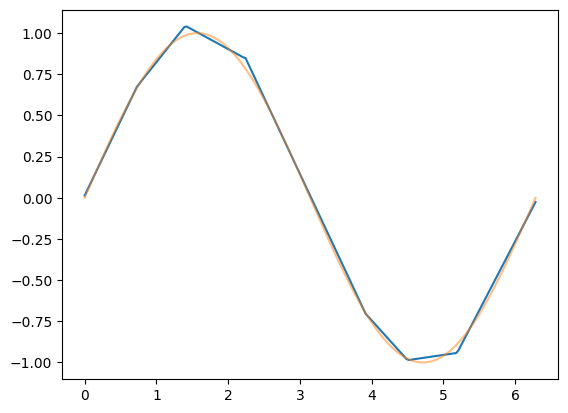

In [69]:
sin_predictions = sin_model(x)
plt.plot(x, sin_predictions.detach().numpy())
plt.plot(x, label, alpha=0.5)


In [77]:
import random

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

In [78]:
sin_model = Sin(8)
epochs = 5000
criterion = torch.nn.L1Loss()
optim = torch.optim.Adam(sin_model.parameters(), lr=0.01)

# Main training loop
for epoch in range(epochs):
    # Pass training data through model
    y_predict = sin_model(x)
    # Compute BCE loss
    loss = criterion(y_predict, label)
    # Backward pass and gradient step
    optim.zero_grad()
    loss.backward()
    optim.step()
    if not epoch % 200:
        # Print out the loss every 10 iterations
        print("epoch {}, loss {}".format(epoch, loss.item()))


epoch 0, loss 1.6307567358016968
epoch 200, loss 0.2646753191947937
epoch 400, loss 0.2623828649520874
epoch 600, loss 0.26436230540275574
epoch 800, loss 0.2618289887905121
epoch 1000, loss 0.2644041180610657
epoch 1200, loss 0.2609071433544159
epoch 1400, loss 0.2608795464038849
epoch 1600, loss 0.2609388828277588
epoch 1800, loss 0.26305684447288513
epoch 2000, loss 0.2605660557746887
epoch 2200, loss 0.2635711431503296
epoch 2400, loss 0.2623286545276642
epoch 2600, loss 0.2606770694255829
epoch 2800, loss 0.26207640767097473
epoch 3000, loss 0.2606714963912964
epoch 3200, loss 0.2602962851524353
epoch 3400, loss 0.26035773754119873
epoch 3600, loss 0.26051828265190125
epoch 3800, loss 0.2603146433830261
epoch 4000, loss 0.2606605887413025
epoch 4200, loss 0.2603382468223572
epoch 4400, loss 0.26029595732688904
epoch 4600, loss 0.26063793897628784
epoch 4800, loss 0.2607709467411041


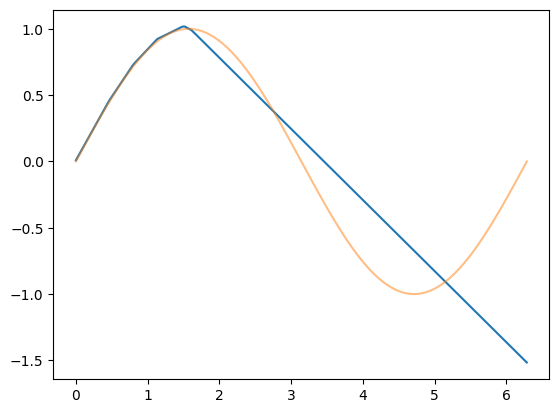

In [79]:
sin_predictions = sin_model(x)
plt.plot(x, sin_predictions.detach().numpy())
plt.plot(x, label, alpha=0.5)


##3. Classifying the spiral dataset

The spiral dataset is a good example of a non-trivial binary classification problem. There are two input features for each data sample: the $x$ and $y$ coordinates of a point. The points belong to one of two classes, depending on which of the two interlocking spirals they lie on. The task is to create a small MLP that takes 2D input

###Generate the spiral dataset

The two classes are points lying on two spirals, rotated by 180 degrees and with some random noise added.

In [80]:
N = 400
training_size = 600
theta = np.sqrt(np.random.rand(N))*2*pi

r_a = 2*theta + pi
data_a = np.array([np.cos(theta)*r_a, np.sin(theta)*r_a]).T
x_a = data_a + np.random.randn(N,2)

r_b = -2*theta - pi
data_b = np.array([np.cos(theta)*r_b, np.sin(theta)*r_b]).T
x_b = data_b + np.random.randn(N,2)

res_a = np.append(x_a, np.zeros((N,1)), axis=1)
res_b = np.append(x_b, np.ones((N,1)), axis=1)

res = np.append(res_a, res_b, axis=0)
np.random.shuffle(res)

X_train_tensor = torch.from_numpy(np.float32(res[:training_size,0:2]))
Y_train_tensor = torch.from_numpy(np.float32(res[:training_size,2])).unsqueeze(1)
X_test_tensor = torch.from_numpy(np.float32(res[training_size:,0:2]))
Y_test_tensor = torch.from_numpy(np.float32(res[training_size:,2])).unsqueeze(1)

Visualise the dataset by plotting the points in the training set and colouring according to the class.

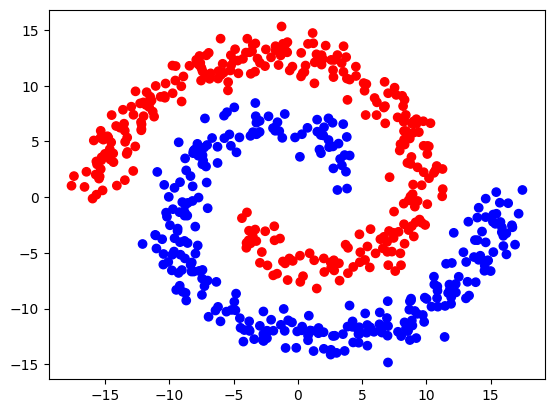

In [81]:
colors = np.where(Y_train_tensor.squeeze(1).numpy() == 0, 'blue', 'red')
plt.scatter(X_train_tensor[:,0].numpy(),X_train_tensor[:,1].numpy(),c=colors)
plt.show()

As you can see, it would not be possible linearly separate these two classes (you can't draw a straight line that divides the points into the two classes). However, we will see that a very small ReLU MLP can do this perfectly.

###Tasks

1. Instantiate a small classification MLP with 2 inputs, one hidden layer with 16 neurons and sigmoid activation on the output. You can reuse the `MLP()` class from earlier for this.
2. Train the MLP to classify the spiral points into two classes.
3. Evaluate by printing classification performance on training and test sets. Plot the spiral points for the test set as above, but colour them according to the class predicted by your MLP rather than the ground truth labels.
4. Let's visualise what the MLP has actually learnt. For any point in 2D space, the MLP assigns a probability. We can visualise this as an image. Use `torch.meshgrid` to create a grid of points over the range -15..15 in $x$ and $y$. Pass all those points through your model to get probabilities. Display the probabilities as an image using matplotlib's `imshow`. You should be able to see the *decision boundary* i.e. the point where the probability is 0.5 and it is separating the two classes. Can you see the influence of ReLU here?
5. As an extra challenge, try to draw the decision boundary over the top of the image as a contour plot. Hint: `skimage.measure.find_contours` will be helpful here.


In [82]:
spiral_model = MLP(2, 16)
epochs = 5000
criterion = torch.nn.BCELoss()
optim = torch.optim.Adam(spiral_model.parameters(), lr=0.01)

# Main training loop
for epoch in range(epochs):
    # Pass training data through model
    y_predict = spiral_model(X_train_tensor)
    # Compute BCE loss
    loss = criterion(y_predict, Y_train_tensor)
    # Backward pass and gradient step
    optim.zero_grad()
    loss.backward()
    optim.step()
    if not epoch % 200:
        # Print out the loss every 10 iterations
        print("epoch {}, loss {}".format(epoch, loss.item()))


epoch 0, loss 2.188882350921631
epoch 200, loss 0.2783673405647278
epoch 400, loss 0.05594123899936676
epoch 600, loss 0.025151805952191353
epoch 800, loss 0.014906447380781174
epoch 1000, loss 0.009920046664774418
epoch 1200, loss 0.007065672893077135
epoch 1400, loss 0.005012929905205965
epoch 1600, loss 0.0038348212838172913
epoch 1800, loss 0.003028881037607789
epoch 2000, loss 0.002444743411615491
epoch 2200, loss 0.0020041572861373425
epoch 2400, loss 0.0016626688884571195
epoch 2600, loss 0.0013929931446909904
epoch 2800, loss 0.0011764522641897202
epoch 3000, loss 0.000999513897113502
epoch 3200, loss 0.0008553309016861022
epoch 3400, loss 0.0007358817965723574
epoch 3600, loss 0.0006357154925353825
epoch 3800, loss 0.0005513112409971654
epoch 4000, loss 0.00047950883163139224
epoch 4200, loss 0.0004181314434390515
epoch 4400, loss 0.0003656721964944154
epoch 4600, loss 0.00032054970506578684
epoch 4800, loss 0.00028156061307527125


In [86]:
# Pass training set set through model
y_predict = spiral_model(X_train_tensor)
# Threshold probabilities to binary classes
predictions = (y_predict>0.5).float()
# Compare predicted classes to labels
correct = (predictions == Y_train_tensor).float().sum()
print("Percent training set correctly classified: {:.2f}%".format(100*correct/training_size))

# Pass test set through model
y_predict = spiral_model(X_test_tensor)
# Threshold probabilities to binary classes
predictions = (y_predict>0.5).float()
# Compare predicted classes to labels
correct = (predictions == Y_test_tensor).float().sum()
print("Percent test set correctly classified: {:.2f}%".format(100*correct/X_test_tensor.shape[0]))

Percent training set correctly classified: 100.00%
Percent test set correctly classified: 99.00%


In [87]:
from skimage import measure

# Create a grid of coordinates
res = 300  # resolution of the grid
x = torch.linspace(-15, 15, res)
y = torch.linspace(-15, 15, res)
xx, yy = torch.meshgrid(x, y, indexing="ij")  # shape (res, res)

# Flatten the grid into (N, 2) shape for model input
grid_points = torch.cat([xx.reshape(-1, 1), yy.reshape(-1, 1)], dim=1)  # (res*res, 2)

# Pass through model (no gradient needed)
with torch.no_grad():
    probs = spiral_model(grid_points).reshape(res, res)  # reshape to (res, res)

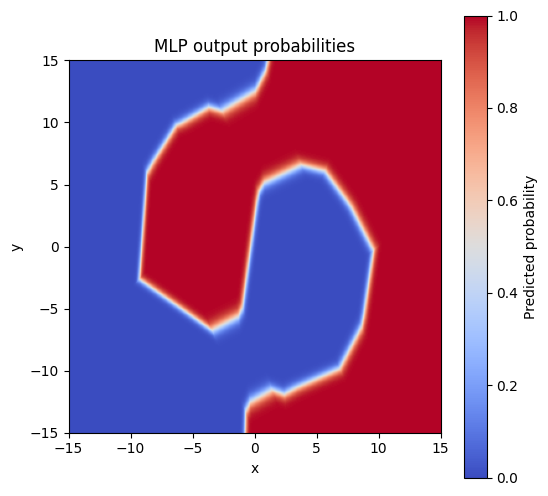

In [88]:
plt.figure(figsize=(6, 6))
plt.imshow(probs.numpy(), extent=(-15, 15, -15, 15), origin='lower', cmap='coolwarm')
plt.colorbar(label='Predicted probability')
plt.title("MLP output probabilities")
plt.xlabel('x')
plt.ylabel('y')
plt.show()


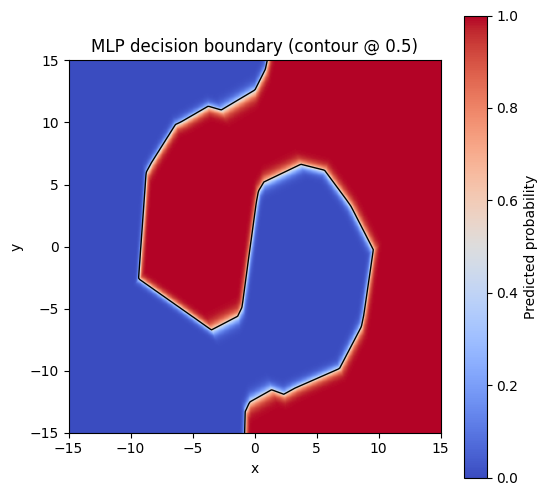

In [89]:
from skimage import measure

# Convert probabilities to numpy for contour detection
probs_np = probs.numpy()

# Find contours at probability = 0.5
contours = measure.find_contours(probs_np, level=0.5)

# Plot the image again
plt.figure(figsize=(6, 6))
plt.imshow(probs_np, extent=(-15, 15, -15, 15), origin='lower', cmap='coolwarm')
plt.colorbar(label='Predicted probability')
plt.title("MLP decision boundary (contour @ 0.5)")

# Overlay the contour lines
for contour in contours:
    # Convert pixel space to coordinate space
    contour = np.array(contour)
    plt.plot(
        np.interp(contour[:, 1], np.arange(res), np.linspace(-15, 15, res)),
        np.interp(contour[:, 0], np.arange(res), np.linspace(-15, 15, res)),
        'k-', linewidth=1
    )

plt.xlabel('x')
plt.ylabel('y')
plt.show()
